# Multi-Fidelity Hyperparameter Optimization with Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/notebook.ipynb)

In this tutorial we present how to use hyperparameter optimization on a basic example from the Keras documentation. We follow the previous tutorial based on the same example and add multi-fidelity to it. The purpose of multi-fidelity is to dynamically manage the budget allocated (also called fidelity) to evaluate an hyperparameter configuration. For example, when training a deep neural network the number of epochs can be continued or stopped based on currently observed performance and some policy.

In DeepHyper, the multi-fidelity agent is designed separately from the hyperparameter search agent. Of course, both can communicate but from an API perspective they are different objects. The multi-fidelity agents are called `Stopper` in DeepHyper and their documentation can be found at [deephyper.stopper](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.stopper.html). 

In this notebook, we will demonstrate how to use multi-fidelity inside sequential Bayesian optimization. When moving to a distributed setting, it is important to use a shared database accessible by all workers otherwise the multi-fidelity scheme may not work properly. An example, of database instanciation for parallel computing is explained in: [Introduction to Distributed Bayesian Optimization (DBO) with MPI (Communication) and Redis (Storage)](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/02_Intro_to_DBO/README.html).

**Reference**:
 This tutorial is based on materials from the Keras Documentation: [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)

Let us start with installing DeepHyper!
    
<div class="alert alert-warning">

<b>Warning</b>
    
This tutorial should be run with `tensorflow>=2.6`.
    
</div>

In [1]:
# !pip install "deephyper[jax-cpu]"
import deephyper
print(deephyper.__version__)

0.6.0


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(4)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

## Imports

In [3]:
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

## The dataset (from Keras.io)

The [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

In [4]:
def load_data():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
    dataframe = pd.read_csv(file_url)

    val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
    train_dataframe = dataframe.drop(val_dataframe.index)

    return train_dataframe, val_dataframe


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing & encoding of features

The next cells use `tf.keras.layers.Normalization()` to apply standard scaling on the features.

Then, the `tf.keras.layers.StringLookup` and `tf.keras.layers.IntegerLookup` are used to encode categorical variables.

In [5]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = (
        tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    )
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Define the run-function with multi-fidelity

The run-function defines how the objective that we want to maximize is computed. It takes a `job` (see [deephyper.evaluator.RunningJob](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.RunningJob.html)) as input and outputs a scaler value or dictionnary (see [deephyper.evaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.html)). The objective is always maximized in DeepHyper. The `job.parameters` contains a suggested configuration of hyperparameters that we want to evaluate. In this example we will search for:

* `units` (default value: `32`)
* `activation` (default value: `"relu"`)
* `dropout_rate` (default value: `0.5`)
* `batch_size` (default value: `32`)
* `learning_rate` (default value: `1e-3`)

A hyperparameter value can be acessed easily in the dictionary through the corresponding key, for example `job["units"]` or `job.parameters["units"]` are both valid. Unlike the previous tutorial in this example we want to use multi-fidelity to dynamically choose the allocated budget of each evaluation. Therefore we use the tensorflow keras integration of stoppers `deephyper.stopper.integration.TFKerasStopperCallback`. The multi-fidelity agent will monitor the validation accuracy (`val_accuracy`) in the context of maximization. This `stopper_callback` is then added to the callbacks used by the model during the training. In order to collect more information about the execution of our job we use the `@profile` decorator on the run-function which will collect execution timings (`timestamp_start` and `timestamp_end`). We will also add `"metadata"` to the output of our function to know how many epochs were used to evaluate each model. To learn more about how the `@profile` decorator can be used check our tutorial on [Understanding the pros and cons of Evaluator parallel backends](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/03_Evaluators/README.html).

```python
    stopper_callback = TFKerasStopperCallback(
        job, 
        monitor="val_accuracy", 
        mode="max"
    )
                                              
    history = model.fit(
        train_ds, 
        epochs=100, 
        validation_data=val_ds, 
        verbose=0,
        callbacks=[stopper_callback]
    )
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {"budget": stopper_callback.budget}
    return {"objective": objective, "metadata": metadata}
```

In [15]:
import json

from deephyper.evaluator import profile, RunningJob
from deephyper.stopper.integration.tensorflow import TFKerasStopperCallback


@profile
def run(job):
    
    config = job.parameters
    
    tf.autograph.set_verbosity(0)
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)

    # Load data and split into validation set
    train_dataframe, val_dataframe = load_data()
    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)
    train_ds = train_ds.batch(config["batch_size"])
    val_ds = val_ds.batch(config["batch_size"])

    # Categorical features encoded as integers
    sex = tf.keras.Input(shape=(1,), name="sex", dtype="int64")
    cp = tf.keras.Input(shape=(1,), name="cp", dtype="int64")
    fbs = tf.keras.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = tf.keras.Input(shape=(1,), name="restecg", dtype="int64")
    exang = tf.keras.Input(shape=(1,), name="exang", dtype="int64")
    ca = tf.keras.Input(shape=(1,), name="ca", dtype="int64")

    # Categorical feature encoded as string
    thal = tf.keras.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = tf.keras.Input(shape=(1,), name="age")
    trestbps = tf.keras.Input(shape=(1,), name="trestbps")
    chol = tf.keras.Input(shape=(1,), name="chol")
    thalach = tf.keras.Input(shape=(1,), name="thalach")
    oldpeak = tf.keras.Input(shape=(1,), name="oldpeak")
    slope = tf.keras.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = tf.keras.layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    x = tf.keras.layers.Dense(config["units"], activation=config["activation"])(
        all_features
    )
    x = tf.keras.layers.Dropout(config["dropout_rate"])(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(all_inputs, output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])
    
    stopper_callback = TFKerasStopperCallback(
        job, 
        monitor="val_accuracy", 
        mode="max"
    )
                                              
    history = model.fit(
        train_ds, 
        epochs=100, 
        validation_data=val_ds, 
        verbose=0,
        callbacks=[stopper_callback]
    )
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata["budget"] = stopper_callback.budget
    return {"objective": objective, "metadata": metadata}

<div class="alert alert-info"> 
<b>Note</b>  
<br>

The objective maximized by DeepHyper is the `"objective"` value returned by the `run`-function.
    
</div>

In this tutorial it corresponds to the validation accuracy of the last epoch of training which we retrieve in the `History` object returned by the `model.fit(...)` call.
    
```python
...
objective = history.history["val_accuracy"][-1]
...
``` 
    
Using an objective like `max(history.history['val_accuracy'])` can have undesired side effects.

For example, it is possible that the training curves will overshoot a local maximum, resulting in a model without the capacity to flexibly adapt to new data in the future.

## Define the Hyperparameter optimization problem

Hyperparameter ranges are defined using the following syntax:

* Discrete integer ranges are generated from a tuple `(lower: int, upper: int)`
* Continuous prarameters are generated from a tuple `(lower: float, upper: float)`
* Categorical or nonordinal hyperparameter ranges can be given as a list of possible values `[val1, val2, ...]`


In [16]:
from deephyper.problem import HpProblem


# Creation of an hyperparameter problem
problem = HpProblem()

# Discrete hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((8, 128), "units", default_value=32)


# Categorical hyperparameter (sampled with uniform prior)
ACTIVATIONS = [
    "elu", "gelu", "hard_sigmoid", "linear", "relu", "selu",
    "sigmoid", "softplus", "softsign", "swish", "tanh",
]
problem.add_hyperparameter(ACTIVATIONS, "activation", default_value="relu")


# Real hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((0.0, 0.6), "dropout_rate", default_value=0.5)


# Discrete and Real hyperparameters (sampled with log-uniform)
problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=32)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)

problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: relu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 32, on log-scale
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.5
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    units, Type: UniformInteger, Range: [8, 128], Default: 32

## Evaluate a default configuration

We evaluate the performance of the default set of hyperparameters provided in the Keras tutorial.

In [18]:
out = run(RunningJob(parameters=problem.default_configuration))
objective_default = out["objective"]
metadata_default = out["metadata"]
    
print(f"Accuracy of the default configuration is {objective_default:.3f}\n with a budget of {metadata_default['budget']}")

out

Accuracy of the default configuration is 0.787
 with a budget of 100


{'objective': 0.7868852615356445,
 'metadata': {'timestamp_start': 1692627006.076231,
  'timestamp_end': 1692627008.611656,
  'loss': '[0.7388495802879333, 0.6523264050483704, 0.6074849367141724, 0.5875506401062012, 0.5609573125839233, 0.5364176630973816, 0.5154970288276672, 0.5150707364082336, 0.49714744091033936, 0.47235098481178284, 0.44334346055984497, 0.40525874495506287, 0.4218010902404785, 0.404602587223053, 0.40189820528030396, 0.38025644421577454, 0.3819867670536041, 0.3854610025882721, 0.41191190481185913, 0.3633726239204407, 0.38953328132629395, 0.38333550095558167, 0.37049752473831177, 0.3487849533557892, 0.32601648569107056, 0.37537238001823425, 0.34992167353630066, 0.3610842227935791, 0.3291627764701843, 0.3573709726333618, 0.3185168504714966, 0.3198896646499634, 0.342100590467453, 0.31612464785575867, 0.33958184719085693, 0.2965970039367676, 0.3082221746444702, 0.3110814690589905, 0.3165033161640167, 0.3095366954803467, 0.3058503568172455, 0.26944229006767273, 0.28905966

## Execute Multi-Fidelity Bayesian Optimization

We create the CBO using the `problem` and `run`-function defined above. When directly passing the `run`-function to the search it is wrapped inside a [deephyper.evaluator.SerialEvaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.SerialEvaluator.html). Then, we also import the [deephyper.stopper.LCModelStopper](https://deephyper.readthedocs.io/en/develop/_autosummary/deephyper.stopper.LCModelStopper.html#deephyper.stopper.LCModelStopper).

In [19]:
from deephyper.search.hps import CBO
from deephyper.stopper import LCModelStopper

In [20]:
# Instanciate the search with the problem and the evaluator that we created before

stopper = LCModelStopper(min_steps=1, max_steps=100)
search = CBO(
    problem,
    run,
    initial_points=[problem.default_configuration],
    stopper=stopper,
    verbose=1,
)

<div class="alert alert-info">
    
<b>Note</b>
    
All DeepHyper's search algorithm have two stopping criteria:
    <ul> 
        <li> <code>`max_evals (int)`</code>: Defines the maximum number of evaluations that we want to perform. Default to <code>-1</code> for an infinite number.</li>
        <li> <code>`timeout (int)`</code>: Defines a time budget (in seconds) before stopping the search. Default to <code>None</code> for an infinite time budget.</li>
    </ul>
    
</div>

In [21]:
results = search.search(max_evals=30)

  0%|          | 0/30 [00:00<?, ?it/s]

The returned `results` is a Pandas Dataframe where columns starting by `"p:"` are hyperparameters, columns starting by `"m:"` are additional metadata (from the user or from the `Evaluator`) as well as the `objective` value and the `job_id`:

* `job_id` is a unique identifier corresponding to the order of creation of tasks.
* `objective` is the value returned by the run-function.
* `m:timestamp_submit` is the time (in seconds) when the task was created by the evaluator since the creation of the evaluator.
* `m:timestamp_gather` is the time (in seconds) when the task was received after finishing by the evaluator since the creation of the evaluator.
* `m:timestamp_start` is the time (in seconds) when the task started to run.
* `m:timestamp_end` is the time (in seconds) when task finished to run.
* `m:budget` is the consumed number of epoch for each evaluation.

In [22]:
results

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:units,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:budget
0,relu,32,0.500000,0.001000,32,0.803279,0,3.554752,7.302983,1.692627e+09,1.692627e+09,"[0.6227220296859741, 0.5570479035377502, 0.538...","[0.5288254618644714, 0.4989699125289917, 0.475...","[0.6487603187561035, 0.7438016533851624, 0.756...","[0.7868852615356445, 0.8032786846160889, 0.819...",35
1,linear,9,0.147090,0.001889,49,0.803279,1,7.347784,10.729823,1.692627e+09,1.692627e+09,"[0.49330684542655945, 0.3671776056289673, 0.30...","[0.3687109649181366, 0.3877825140953064, 0.386...","[0.7479338645935059, 0.8264462947845459, 0.851...","[0.8032786846160889, 0.868852436542511, 0.8524...",27
2,softsign,12,0.499104,0.000029,100,0.786885,2,10.749194,14.626382,1.692627e+09,1.692627e+09,"[0.710996150970459, 0.7085673213005066, 0.7007...","[0.6798619031906128, 0.6712697148323059, 0.663...","[0.5289255976676941, 0.5495867729187012, 0.561...","[0.5409836173057556, 0.5409836173057556, 0.557...",59
3,softsign,27,0.582597,0.000215,97,0.868852,3,14.645453,18.470026,1.692627e+09,1.692627e+09,"[0.6582441329956055, 0.6144227385520935, 0.614...","[0.6063965559005737, 0.5792577862739563, 0.555...","[0.6157024502754211, 0.6528925895690918, 0.648...","[0.7213114500045776, 0.7540983557701111, 0.737...",64
4,selu,28,0.469018,0.000618,110,0.786885,4,18.490789,21.121490,1.692627e+09,1.692627e+09,"[0.6250562071800232, 0.5189632177352905, 0.483...","[0.49002861976623535, 0.423252135515213, 0.386...","[0.6818181872367859, 0.7231404781341553, 0.731...","[0.7704917788505554, 0.8196721076965332, 0.786...",4
5,linear,15,0.289261,0.000777,68,0.819672,5,21.140275,23.720370,1.692627e+09,1.692627e+09,"[0.6295762062072754, 0.4781874716281891, 0.421...","[0.5124895572662354, 0.433324933052063, 0.4010...","[0.6735537052154541, 0.7603305578231812, 0.801...","[0.8032786846160889, 0.7868852615356445, 0.803...",4
6,elu,133,0.007165,0.000024,88,0.688525,6,23.738940,26.728599,1.692627e+09,1.692627e+09,"[0.6447474956512451, 0.6408497095108032, 0.641...","[0.597851037979126, 0.5967557430267334, 0.5956...","[0.6280992031097412, 0.6322314143180847, 0.640...","[0.688524603843689, 0.688524603843689, 0.68852...",4
7,elu,184,0.365660,0.000276,126,0.704918,7,26.748085,29.293730,1.692627e+09,1.692627e+09,"[0.6677700281143188, 0.6242449879646301, 0.632...","[0.6279993057250977, 0.612653374671936, 0.5987...","[0.6239669322967529, 0.6652892827987671, 0.673...","[0.7049180269241333, 0.7213114500045776, 0.721...",4
8,linear,27,0.410357,0.003974,10,0.819672,8,29.312796,32.318316,1.692627e+09,1.692627e+09,"[0.6348783373832703, 0.4910481572151184, 0.433...","[0.5030055046081543, 0.4379017949104309, 0.406...","[0.7066115736961365, 0.7438016533851624, 0.801...","[0.7540983557701111, 0.8032786846160889, 0.803...",31
9,gelu,37,0.586930,0.001828,94,0.786885,9,32.583841,35.622722,1.692627e+09,1.692627e+09,"[0.646159291267395, 0.5308106541633606, 0.4458...","[0.5199227333068848, 0.44885024428367615, 0.40...","[0.6363636255264282, 0.7479338645935059, 0.809...","[0.8196721076965332, 0.7868852615356445, 0.786...",35


Now that the search is over, let us print the best configuration found during this run.

In [24]:
i_max = results.objective.argmax()
best_job = results.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.787. 
The best configuration found by DeepHyper has an accuracy 0.869, 
discovered after 18.47 secondes of search.



{'p:activation': 'softsign',
 'p:batch_size': 27,
 'p:dropout_rate': 0.5825972321970286,
 'p:learning_rate': 0.0002146492013936,
 'p:units': 97,
 'objective': 0.868852436542511,
 'job_id': 3,
 'm:timestamp_submit': 14.645452976226808,
 'm:timestamp_gather': 18.47002601623535,
 'm:timestamp_start': 1692627056.0797062,
 'm:timestamp_end': 1692627059.903903,
 'm:loss': '[0.6582441329956055, 0.6144227385520935, 0.6145278215408325, 0.6029292941093445, 0.5701202154159546, 0.5590323209762573, 0.5266819000244141, 0.5313710570335388, 0.5190641283988953, 0.48551449179649353, 0.4518640339374542, 0.4618057608604431, 0.47630706429481506, 0.4841085374355316, 0.46425509452819824, 0.46001386642456055, 0.4311169981956482, 0.42034876346588135, 0.4447265863418579, 0.4271446466445923, 0.41852933168411255, 0.42826342582702637, 0.4135468304157257, 0.40737172961235046, 0.3894239068031311, 0.38594695925712585, 0.4143550395965576, 0.3991055190563202, 0.39989709854125977, 0.3991136848926544, 0.3789837062358856,

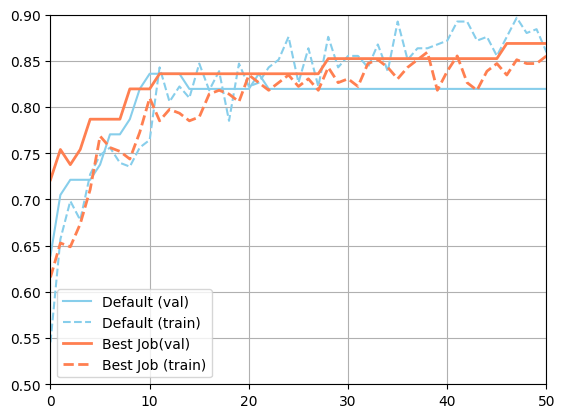

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.xlim(0,50)
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()

We can observe an improvement of more than 3% in accuracy. We can retrieve the corresponding hyperparameter configuration with the number of epochs used for this evaluation (32).